In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import os
import glob
import datetime
import matplotlib.pyplot as plt
from functions import preproc_nemo
from functions import yearFraction
expname='res1_a'
expdir=os.path.join('/ec/res4/scratch/itas/ece4/', expname, 'output', 'nemo')

In [7]:
futtime = yearFraction(datetime.datetime.now())

In [8]:
domain = xr.open_dataset(os.path.join(expdir, '..', '..', 'domain_cfg.nc'))
vol = domain['e1t']*domain['e2t']*domain['e3t_0']
area = domain['e1t']*domain['e2t']
dz = domain['e3t_0']

In [9]:
domain

<xarray.Dataset>
Dimensions:        (y: 331, x: 360, z: 75, time_counter: 1)
Coordinates:
  * time_counter   (time_counter) float32 0.0
Dimensions without coordinates: y, x, z
Data variables: (12/50)
    nav_lon        (y, x) float32 ...
    nav_lat        (y, x) float32 ...
    nav_lev        (z) float32 ...
    jpiglo         int32 ...
    jpjglo         int32 ...
    jpkglo         int32 ...
    ...             ...
    mask_csglo     (time_counter, y, x) int32 ...
    mask_csemp     (time_counter, y, x) int32 ...
    mask_csrnf     (time_counter, y, x) int32 ...
    mask_csgrpglo  (time_counter, y, x) int32 ...
    mask_csgrpemp  (time_counter, y, x) int32 ...
    mask_csgrprnf  (time_counter, y, x) int32 ...
Attributes:
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1 2]
    DOMAIN_size_global:      [360 331]
    DOMAIN_size_local:       [360 331]
    DOMAIN_position_first:   [1 1]
    DOMAIN_position_last:    [360 331]
    DOMAIN_halo_size_start:  [0 0]
    DOMAIN_halo_size_end:    [0 0]
    DOMAIN_type:             BOX

In [10]:
filelist = glob.glob(os.path.join(expdir, 'res1_oce_1m_T_*.nc'))
data = xr.open_mfdataset(filelist, preprocess=preproc_nemo)
data

<xarray.Dataset>
Dimensions:               (y: 331, x: 360, z: 75, time: 72, axis_nbounds: 2)
Coordinates:
    nav_lat_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
  * z                     (z) float32 0.5 1.55 2.661 ... 5.698e+03 5.902e+03
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1990-01-16T12:00:00 ... 1995-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/25)
    deptht_bounds         (time, z, axis_nbounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    e3t                   (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    thetao                (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    so                    (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    ...                    ...
    qt_oce                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sfx                   (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    taum                  (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    windsp                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    precip                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    snowpre               (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    name:         output/nemo/res1_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2023-Oct-05 15:45:43 GMT
    uuid:         379edbf8-c29b-4a2a-8027-553581697456

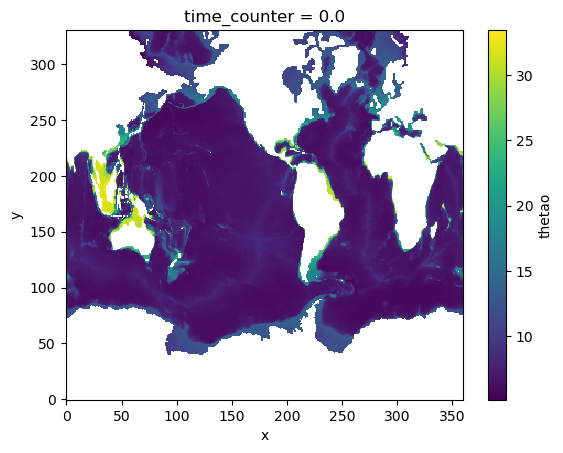

In [11]:
map_aveT = data.thetao.weighted(dz).mean(dim=['time', 'z']).plot()

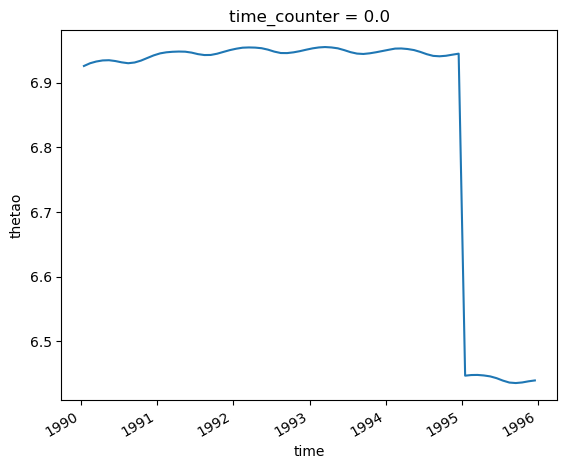

In [12]:
out_global_temp = data.thetao.weighted(vol).mean(dim=['z', 'y', 'x']).plot()

Global temperature projection 4.752804673601105


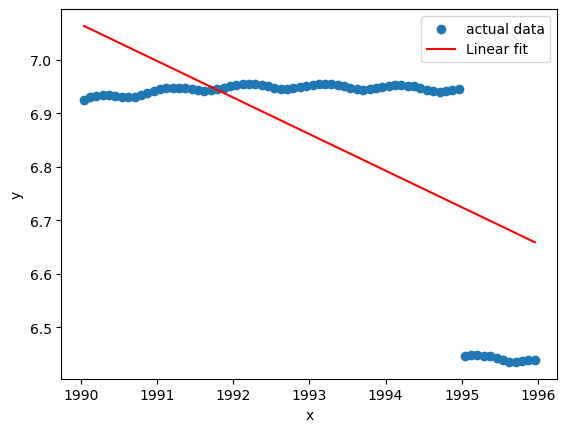

In [13]:
# global temperature - projection in the future
Yd = data.thetao.weighted(vol).mean(dim=['z', 'y', 'x']).values
dates = pd.to_datetime(data['time'].values)
Xd = [[yearFraction(t)] for t in dates]
model=LinearRegression()
model.fit(Xd, Yd)
mp = model.coef_
qp = model.intercept_
Y_pred = model.predict([[futtime]])
print(f'Global temperature projection {Y_pred[0][0]}')
Yp = mp * Xd + qp
plt.scatter(Xd, Yd, label='actual data')
plt.plot(Xd, Yp, 'r-', label='Linear fit')  # Replace with your desired curve
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


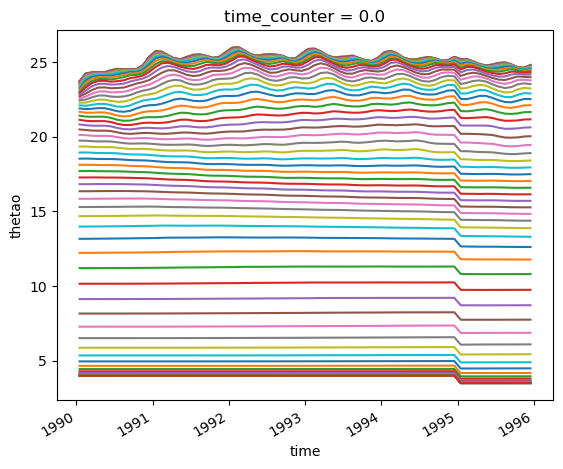

In [14]:
outz=data.thetao.weighted(area).mean(dim=['y', 'x']).plot(x='time', hue='z')
plt.legend().set_visible(False)
plt.show()

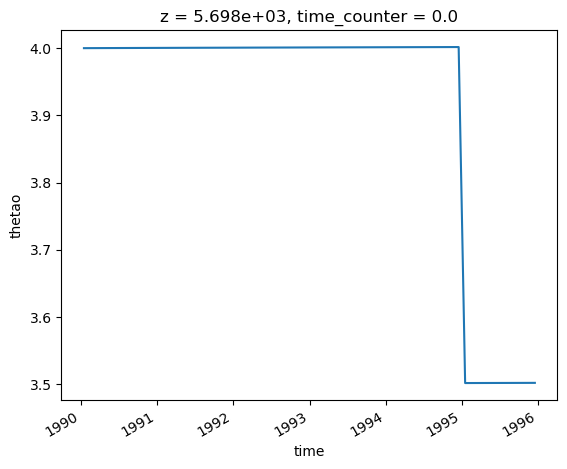

In [15]:
thetaz = data.thetao.isel(z=73).weighted(area).mean(dim=['y', 'x']).plot(x='time',hue='z')

In [16]:
# vertical profiles of temperature - projection
coefficients = []
intercepts = []
Y_pred = []
Z_pred = []
zf_values=data['z'].values
for i in range(len(zf_values)-1):    
    Yd = data.thetao.isel(z=i).weighted(area).mean(dim=['y', 'x']).values
    dates = pd.to_datetime(data['time'].values)
    Xd = [[yearFraction(t)] for t in dates]
    model=LinearRegression()
    model.fit(Xd, Yd)
    coefficients.append(model.coef_[0][0])
    intercepts.append(model.intercept_[0])
    Y_pred.append(model.predict([[futtime]])[0][0])
    Z_pred.append(-zf_values[i])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


In [17]:
Ya = data.thetao.isel(time=t).weighted(area).mean(dim=['y', 'x']).values
Za = data['z'].values
plt.plot(Ya, -Za)
plt.plot(Y_pred, Z_pred) 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

NameError: name 't' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


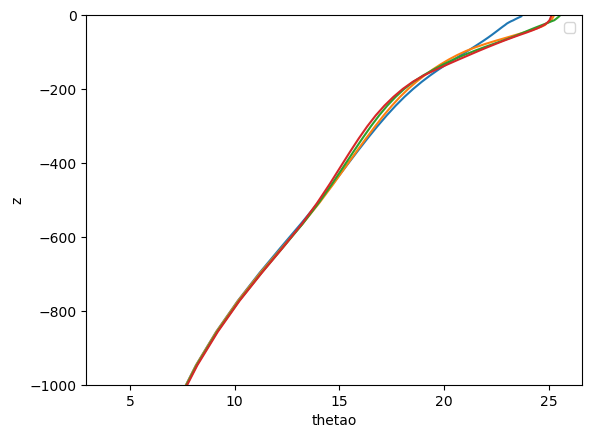

In [ ]:
tf=data['time'].values
plt.figure()
for t in range(0,len(tf),15):
    Ya = data.thetao.isel(time=t).weighted(area).mean(dim=['y', 'x']).values
    Za = data['z'].values
    plt.plot(Ya, -Za)
plt.ylim(-1000, 0)
plt.xlabel('thetao')
plt.ylabel('z')
plt.legend()
plt.show()
#plt.plot(Y_pred, -Z_pred, 'r-', c='blue', label='project')  # Replace with your desired curve
#plt.xlabel('theta')
#plt.ylabel('z')
#plt.legend()
#plt.show()

Global Heat content projection 71921668574.05737


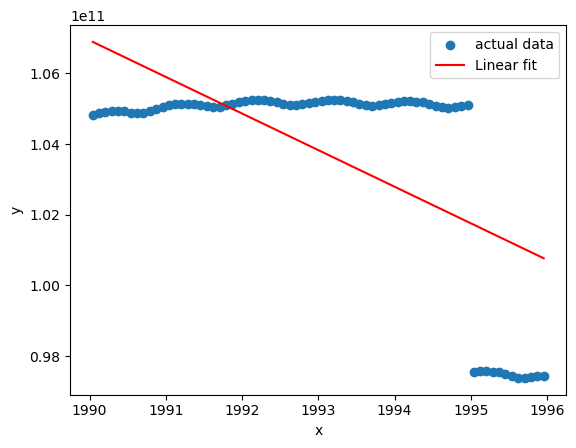

In [18]:
# global heat content - projections 
Yd = data.heatc.weighted(area).mean(dim=['y', 'x']).values
dates = pd.to_datetime(data['time'].values)
Xd = [[yearFraction(t)] for t in dates]
model=LinearRegression()
model.fit(Xd, Yd)
mp = model.coef_
qp = model.intercept_
Y_pred = model.predict([[futtime]])
print(f'Global Heat content projection {Y_pred[0][0]}')
Yp = mp * Xd + qp
plt.scatter(Xd, Yd, label='actual data')
plt.plot(Xd, Yp, 'r-', label='Linear fit')  # Replace with your desired curve
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [19]:
print(Xd)

[[1990.0424657534247], [1990.123287671233], [1990.204109589041], [1990.2876712328766], [1990.3712328767124], [1990.454794520548], [1990.5383561643835], [1990.623287671233], [1990.7068493150684], [1990.7904109589042], [1990.8739726027397], [1990.9575342465753], [1991.0424657534247], [1991.123287671233], [1991.204109589041], [1991.2876712328766], [1991.3712328767124], [1991.454794520548], [1991.5383561643835], [1991.623287671233], [1991.7068493150684], [1991.7904109589042], [1991.8739726027397], [1991.9575342465753], [1992.042349726776], [1992.1243169398906], [1992.2062841530055], [1992.2896174863388], [1992.372950819672], [1992.4562841530055], [1992.5396174863388], [1992.6243169398906], [1992.707650273224], [1992.7909836065573], [1992.8743169398906], [1992.957650273224], [1993.0424657534247], [1993.123287671233], [1993.204109589041], [1993.2876712328766], [1993.3712328767124], [1993.454794520548], [1993.5383561643835], [1993.623287671233], [1993.7068493150684], [1993.7904109589042], [19

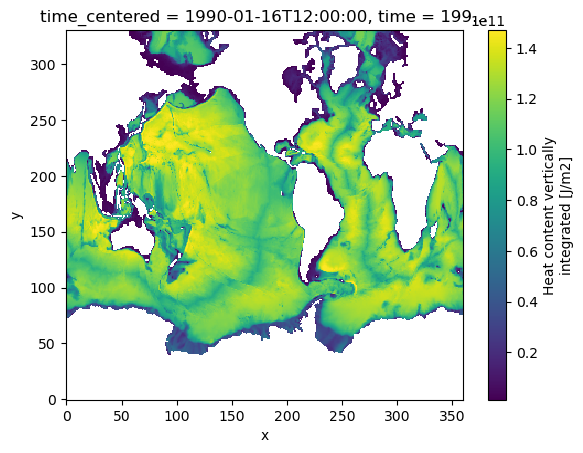

In [ ]:
heat = data.heatc.isel(time=0).plot()

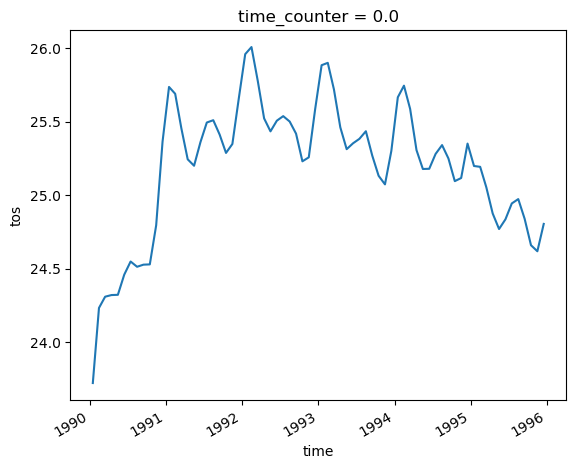

In [ ]:
out_sst = data.tos.weighted(area).mean(dim=['y', 'x']).plot()